In [1]:
%matplotlib inline
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import utils
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_excel(r'./dataset.xlsx')
df = df.set_index(df.iloc[:,0].name)

## Random Forest

In [3]:
attributes = [col for col in df.columns if col != 'Electronic labeler']
X = df[attributes].values
y = df['Electronic labeler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y)

In [4]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=24, min_samples_split=150, 
                             min_samples_leaf=200, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7931034482758621
F1-score [0.87734728 0.33930858]
              precision    recall  f1-score   support

           0       0.79      0.98      0.88      3755
           1       0.81      0.21      0.34      1233

    accuracy                           0.79      4988
   macro avg       0.80      0.60      0.61      4988
weighted avg       0.80      0.79      0.74      4988



In [5]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.7922300922944838,
  'recall': 0.9829560585885486,
  'f1-score': 0.8773472783456144,
  'support': 3755},
 '1': {'precision': 0.8054711246200608,
  'recall': 0.21492295214922952,
  'f1-score': 0.33930857874519843,
  'support': 1233},
 'accuracy': 0.7931034482758621,
 'macro avg': {'precision': 0.7988506084572723,
  'recall': 0.5989395053688891,
  'f1-score': 0.6083279285454064,
  'support': 4988},
 'weighted avg': {'precision': 0.7955031862915641,
  'recall': 0.7931034482758621,
  'f1-score': 0.7443477361228171,
  'support': 4988}}

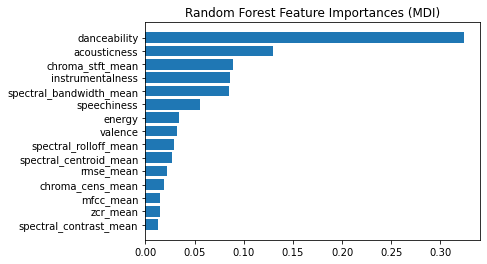

In [6]:
nbr_features = 15

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(attributes)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [7]:
result = permutation_importance(clf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2)

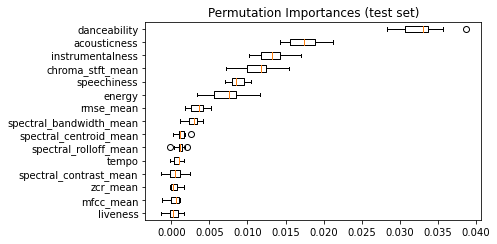

In [8]:
sorted_idx = result.importances_mean.argsort()[-nbr_features:]
plt.figure(figsize=(7, 3.5))
#fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(attributes)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

### Cross validation

In [9]:
clf = RandomForestClassifier()
scores = cross_val_score(clf, X, y, cv=5)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.807 +/- 0.014


### Tuning parametri

In [10]:
param_list = {'max_depth': [None] + list(np.arange(2, 30)),
              'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 60, 100],
              'min_samples_leaf': [1, 2, 5, 10, 20, 30, 40, 50, 60, 100],
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=10)
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.822373696872494
F1-score [0.88941588 0.54887984]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3755
           1       0.74      0.44      0.55      1233

    accuracy                           0.82      4988
   macro avg       0.79      0.69      0.72      4988
weighted avg       0.81      0.82      0.81      4988



In [11]:
confusion_matrix(y_test, y_pred)

array([[3563,  192],
       [ 694,  539]])

In [12]:
random_search.cv_results_['params'][random_search.cv_results_['rank_test_score'][0]]

{'min_samples_split': 40, 'min_samples_leaf': 20, 'max_depth': 6}

In [13]:
fpr1, tpr1, _ = roc_curve(y_test, y_pred)
roc_auc1 = auc(fpr1, tpr1)

roc_auc1 = roc_auc_score(y_test, y_pred)
roc_auc1

0.6930066750685487

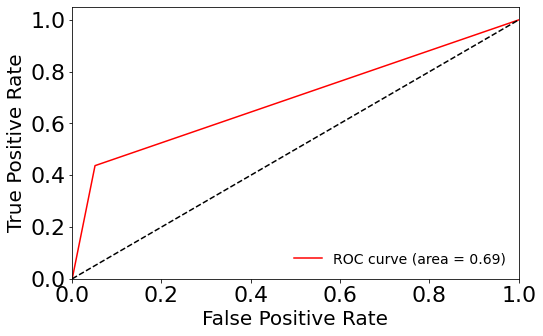

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(fpr1, tpr1, label='ROC curve (area = %0.2f)' % (roc_auc1), c = 'r')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0],)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

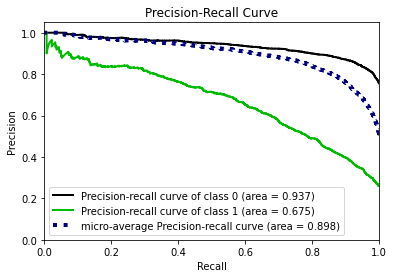

In [15]:
y_score = clf.predict_proba(X_test)

plot_precision_recall(y_test, y_score)
plt.show()

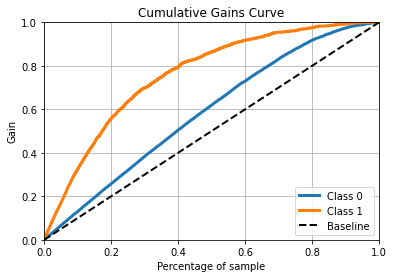

In [16]:
plot_cumulative_gain(y_test, y_score)
plt.show()

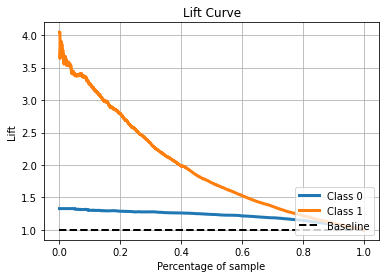

In [17]:
plot_lift_curve(y_test, y_score)
plt.show()

## Bagging

In [18]:
scaler = preprocessing.StandardScaler()

df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']] = scaler.fit_transform(df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']])

attributes = [col for col in df.columns if col != 'Electronic labeler']
X = df[attributes].values
y = df['Electronic labeler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y)

In [19]:
clf = BaggingClassifier(base_estimator=None, n_estimators=20, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8089414595028067
F1-score [0.88065122 0.52134606]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3755
           1       0.68      0.42      0.52      1233

    accuracy                           0.81      4988
   macro avg       0.76      0.68      0.70      4988
weighted avg       0.79      0.81      0.79      4988



In [20]:
fpr2, tpr2, _ = roc_curve(y_test, y_pred)
roc_auc2 = auc(fpr2, tpr2)

roc_auc2 = roc_auc_score(y_test, y_pred, average=None)
roc_auc2

0.6786380527504284

In [21]:
clf = BaggingClassifier(base_estimator=SVC(C=1000, kernel='rbf', gamma=0.1), n_estimators=20, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7943063352044908
F1-score [0.86702955 0.5460177 ]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3755
           1       0.60      0.50      0.55      1233

    accuracy                           0.79      4988
   macro avg       0.72      0.70      0.71      4988
weighted avg       0.78      0.79      0.79      4988



In [22]:
fpr3, tpr3, _ = roc_curve(y_test, y_pred)
roc_auc3 = auc(fpr3, tpr3)

roc_auc3 = roc_auc_score(y_test, y_pred, average=None)
roc_auc3

0.6956088826684723

In [23]:
clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=20, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8137530072173216
F1-score [0.88483947 0.51335778]
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      3755
           1       0.72      0.40      0.51      1233

    accuracy                           0.81      4988
   macro avg       0.78      0.67      0.70      4988
weighted avg       0.80      0.81      0.79      4988



In [24]:
fpr4, tpr4, _ = roc_curve(y_test, y_pred)
roc_auc4 = auc(fpr4, tpr4)

roc_auc4 = roc_auc_score(y_test, y_pred, average=None)
roc_auc4

0.6739353746235082

In [25]:
clf = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=22, weights='distance', metric='minkowski', leaf_size=101), n_estimators=20, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7987169206094628
F1-score [0.87647638 0.45670996]
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      3755
           1       0.69      0.34      0.46      1233

    accuracy                           0.80      4988
   macro avg       0.75      0.65      0.67      4988
weighted avg       0.78      0.80      0.77      4988



In [26]:
fpr5, tpr5, _ = roc_curve(y_test, y_pred)
roc_auc5 = auc(fpr5, tpr5)

roc_auc5 = roc_auc_score(y_test, y_pred, average=None)
roc_auc5

0.6454282638018193

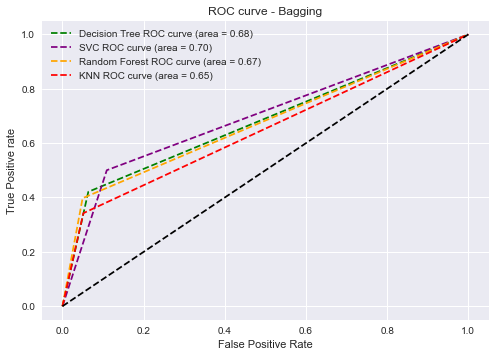

In [27]:
plt.style.use('seaborn')

#plot roc curves
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Decision Tree ROC curve (area = %0.2f)' % (roc_auc2))
plt.plot(fpr3, tpr3, linestyle='--',color='purple', label='SVC ROC curve (area = %0.2f)' % (roc_auc3))
plt.plot(fpr4, tpr4, linestyle='--',color='orange', label='Random Forest ROC curve (area = %0.2f)' % (roc_auc4))
plt.plot(fpr5, tpr5, linestyle='--',color='red', label='KNN ROC curve (area = %0.2f)' % (roc_auc5))
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC curve - Bagging')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

## Boosting

In [28]:
scaler = preprocessing.StandardScaler()

df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']] = scaler.fit_transform(df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']])

attributes = [col for col in df.columns if col != 'Electronic labeler']
X = df[attributes].values
y = df['Electronic labeler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y)

In [29]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=20, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8027265437048917
F1-score [0.87669173 0.50701403]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3755
           1       0.66      0.41      0.51      1233

    accuracy                           0.80      4988
   macro avg       0.75      0.67      0.69      4988
weighted avg       0.79      0.80      0.79      4988



In [30]:
fpr6, tpr6, _ = roc_curve(y_test, y_pred)
roc_auc6 = auc(fpr6, tpr6)

roc_auc6 = roc_auc_score(y_test, y_pred, average=None)
roc_auc6

0.6709695534367262

In [31]:
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=20, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.816158781074579
F1-score [0.88604449 0.52462416]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      3755
           1       0.73      0.41      0.52      1233

    accuracy                           0.82      4988
   macro avg       0.78      0.68      0.71      4988
weighted avg       0.81      0.82      0.80      4988



In [32]:
fpr7, tpr7, _ = roc_curve(y_test, y_pred)
roc_auc7 = auc(fpr7, tpr7)

roc_auc7 = roc_auc_score(y_test, y_pred, average=None)
roc_auc7

0.6798909915192828

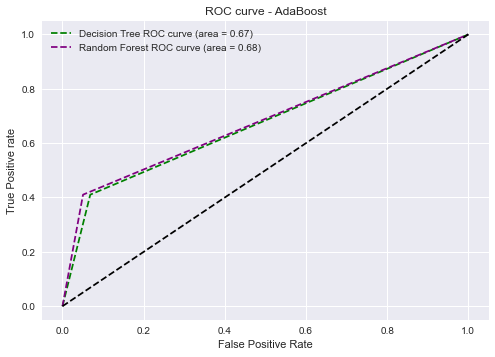

In [33]:
plt.style.use('seaborn')

plt.plot(fpr6, tpr6, linestyle='--',color='green', label='Decision Tree ROC curve (area = %0.2f)' % (roc_auc6))
plt.plot(fpr7, tpr7, linestyle='--',color='purple', label='Random Forest ROC curve (area = %0.2f)' % (roc_auc7))

plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC curve - AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()